# Lab 5 Sieci Neuronowe w Automatyce -  Q-learning

Celem ćwiczenia jest implementacja algorytmu DQN, który nauczy się sterować odwróconym wahadłem utrzymując je w górze.

Punktacja: 
* 8 pkt. działający kod (wahadło utrzymane w górze powyżej 200 kroków)
* 2 pkt. odpowiedzi na pytania

Imię i nazwisko: ...

In [ ]:
# doinstalowujemy potrzebne biblioteki
!pip install gymnasium imageio ffmpeg

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
from gymnasium.wrappers import TimeLimit
import tensorflow as tf
import numpy as np
import numpy.testing as npt
import random

In [3]:
# tworzymy środowisko
env = gym.make('CartPole-v1', render_mode="rgb_array")
observation, _ = env.reset()
print(observation)

[-0.01899745 -0.01913439 -0.03491143 -0.01571686]


#### Obserwacje (stan)
Obserwacje to:
- $x$ - pozycja wózka
- $\dot{x}$ - prędkość wózka
- $\theta$ - kąt nachylenia wahadła
- $\dot{\theta}$ - prędkość kątowa wahadła

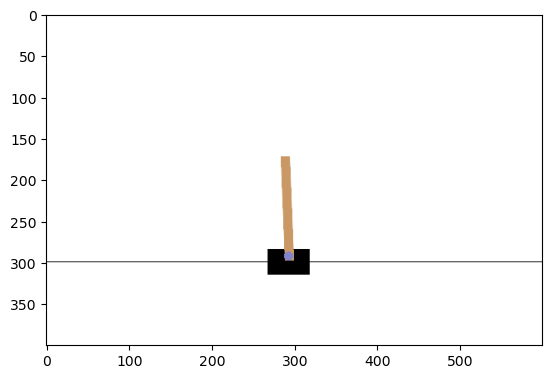

In [3]:
plt.imshow(env.render());

In [4]:
env.action_space

Discrete(2)

#### Akcje
Mamy dwie możliwe akcje:
* 0 - przesuń wózek w lewo
* 1 - przesuń wózek w prawo

#### Nagrody
Za każdy krok, póki wahadło nie spadnie, dostajemy nagrodę 1.

### 1. Losowy agent
Zaimplementować agenta wykonującego losowe akcje. Uruchomić 5 epizodów. Dla każdego epizodu policzyć skumuowane nagrody i wyświetlić. 

In [4]:
rewards_list = []
for i in range(5):
    observation, info = env.reset()
    done = False
    rewards = 0
    while not done:
        action = #TODO wybrać losową akcję
        observation, reward, terminated, truncated, info = #TODO wykonać akcję
        done = terminated or truncated
        #TODO: dodać otrzymaną nagrodę do skumulowanej angrody
    env.close()
    #TODO: dodać skumulowane nagrody do listy nagród

SyntaxError: invalid syntax (1315317361.py, line 7)

In [6]:
rewards_list

[17.0, 23.0, 17.0, 70.0, 31.0]

In [7]:
# tworzymy środowisko i ustawiamy maksymalną liczbę kroków
max_steps = 300
env = gym.make('CartPole-v1', render_mode="rgb_array")

#### Parametry
* state_size - rozmiar przestrzeni stanu środowiska
* buffer_size - rozmiar bufora
* epsilon - początkowa wartość $\epsilon$ do stosowania polityki $\epsilon$ zachłannej
* epsilon_decay - liczba przez którą mnożymy epsilon po każdym epizodzie
* epsilon_min - ale epsilon nie powinien spadać poniżej epsilon_min
* gamma - współczynnik dyskontujący
* batch_size - rozmiar batcha

In [8]:
state_size = 4
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.99
gamma = 0.95
batch_size = 32
buffer_size = 1000

#### 2. Tworzenie DQN
Zaimplementuj funkcję tworzącą sieć aproksymującą Q - wartości. Zastosuj:
* Dwie warstwy ukryte o 32 neuronach i funkcji aktywacji relu
* Liniową funkcję aktywacji w warstwie wyjściowej
* Optymalizator Adam i błąd średniokwadratowy jako funkcję straty
* Liczba wejść sieci odpowiada rozmiarowi stanu środowiska
* Liczba wyjść sieci odpowiada liczbie akcji

In [9]:
def make_network():
    model = tf.keras.Sequential()
    #TODO dodać do sieci warstwy
    model.compile(#TODO parametry)
    return model

In [10]:
model = make_network()
state = np.array([[-0.005, 0.001, 0.0001, 0.0001]])
q_values = model.predict(state, verbose=0)
print(q_values)

[[-0.00020851 -0.00032942]]


In [11]:
assert(q_values.shape == (1, 2))

In [12]:
# wskazówka do 3
q_values.argmax()

0

In [5]:
# podmiana wag na konkretne wartości - tylko w celu testu poprawności implementacji w assercie poniżej
np.random.seed(0)
weight_sizes = [(4, 32), (32,), (32, 32), (32,), (32, 2), (2,)]
new_weights = [np.random.normal(size=size) for size in weight_sizes]
model.set_weights(new_weights)

NameError: name 'model' is not defined

In [ ]:
npt.assert_allclose(model.predict(state, verbose=0), np.array([[-3.4027915, -6.6636534]]),
                    rtol=1e-5, atol=1e-8)

#### 3. Wybór akcji
Zaimplementuj funkcję get_action, realizującą strategię epsilon-zachłanną, która z prawdopodopieństwem epsilon wybiera losową akcję, a z prawdopodobieństwem 1 - epsilon akcję o największej Q-wartości dla danego stanu 
* Do losowania wykorzystać funkcję np.random.uniform()
* Do wyboru akcji wywołać predykcję sieci dla danego stanu (model.predict(...)) i wykorzystać funkcję argmax
* W funkcji predict zastosować argument verbose=0, który spowoduje, że nie będzie wydruków

In [13]:
def get_action(env, state, model, epsilon):
    #TODO
    return action

In [14]:
# tu powinin być losowy wynik - mozna sobie uruchomić kilka razy
get_action(env, state, model, 1)

0

In [15]:
# a tu predykcja sieci
assert(get_action(env, state, model, 0) == 0)

0

#### 4. Aktualizacja wag modelu
Zaimplementować funkcję aktualizującą wagi modelu:

1. Wybierz batch losowych próbek z bufora
2. Oblicz wartość $y$ ($y$ - oczekiwane wyjścia sieci, do których będziemy douczać):
  
    $$y_a = \begin{cases} r & \text{jeśli to koniec epizodu} \\ r + \gamma \max_{a'} Q(s', a') &      \text{w przeciwnym przypadku} \end{cases}$$
Wskazówka: zamiast if można wykorzystać w drugim członie równania mnożenie przez (1-dones).

Chcemy aktualizaować $Q(s, a)$ tylko dla akcji $a$, która faktycznie została wykonana. Nasza sieć ma dwa wyjścia (dla dwóch akcji), więc do funkcji fit zawsze musimy podawać jako $y$ macierz o rozmiarze rozmiar batcha $\times$ liczba możliwych akcji.

Aby nie aktualizować wyjscia sieci dla drugiej (niewykonanej) akcji realizujemy punkt 2 następująco:

* wyliczamy wartość $y_a$ wg wzoru powyżej (wymiar rozmiar batcha)
* wyliczmy $y$ jako predykcję sieci dla $s$ (wymiar rozmiar batcha $\times$ liczba akcji)
* podmieniamy wartość $y$ na $y_a$ dla akcji $a$
* w ten sposób wartość $y$ dla niewybranej akcji jest taka sama jak predykcja sieci, więc błąd jest 0, więc nie aktualizujemy

Uwaga: w tym ćwiczeniu nie korzystamy z Q-tabeli, aproksymujemy Q-wartości z wykorzystaniem sieci neuronowej.

3. Zaktualizuj wagi sieci neuronowej

Bufor jest listą krotek zawierających (state, action, reward, new_state, done)

In [23]:
state = np.array([[-0.005, 0.001, 0.0001, 0.0001]])
new_state = np.array([[0.005, 0.001, 0.0001, 0.0001]])
buffer = [(state, 0, 1, new_state, True),
          (state, 1, 1, new_state, False)]

In [29]:
def update(model, buffer, batch_size):
    # TODO jeśli rozmiar bufora jest mniejszy niż batch_size wyjdź z funkcji poprzez return

    minibatch = # TODO wybierz buffer_size losowych próbek z bufora (funkcja samle z modułu random)

    # wyciągamy z bufora odpowienie dane i zamieniamy na macierze numpy
    states, actions, rewards, new_states, dones = zip(*minibatch)
    actions, rewards, dones = np.array(actions), np.array(rewards), np.array(dones)
    # states to krotka (o batch_size elementach) np.arrayów o rozmiarze 1 x state size (new states też)
    states = # TODO zamień na np.array i zmień rozmiar na batch_size x state_size
    new_states = # TODO zamień na np.array i zmień rozmiar na batch_size x state_size

    y_a = # wyznać y_a według wzoru w 2
    y = # wyznacz y jako predykcję sieci dla states
        
    for i, action in enumerate(actions):
        # TODO podmień wartość y dla odpowiedniej akcji na y_a
        
    # ucz model przez jedną epokę, zastosuj verbose=0, aby uniknąć wydruków

In [30]:
update(model, buffer, 2)

In [ ]:
npt.assert_allclose(model.layers[2].get_weights()[1], np.array([-0.08411561, -0.563301]),
                    rtol=1e-5, atol=1e-8)

#### 5. Epizod z wykorzystaniem zachłannej polityki
Zaimplementuj funkcję, która wykona jeden epizod, realizując politykę zachłanną (zawsze wybieramy akcję o najlepszej q-vartości) i zwróci wartość skumulowanej nagrody.

In [19]:
def run_eval_episode(env, model):
    state, info = env.reset()
    state = state.reshape(1, state_size)
    done = False
    rewards = 0
    for j in range(max_steps):
        q_values = #TODO predykcja sieci dla danego stanu
        action = #TODO wybierz najlepszą akcję
        state, reward, terminated, truncated, info = env.step(action)
        state = state.reshape(1, state_size)
        done = terminated or truncated
        # TODO aktualizacja sumy nagród
        if done:
            break
    env.close()
    return rewards

In [20]:
run_eval_episode(env, model)

9.0

#### Algorytm uczenia
Zaimplementuj pętlę algorymu uczenia:

1. Zainicjalizuj sieć neuronową i pusty bufor próbek.
2. Z prawdopodobieństwem $\epsilon$ wybierz losową akcję, w przeciwnym przypadku wybierz akcję zgodnie z polityką
3. Poprzez interakcje ze środowiskiem uzyskaj $(s, a, r, s', done)$
4. Dodaj $(s, a, r, s', done)$ do bufora
5. Zaktualizuj wagi sieci neuronowej
6. Zaktualizuj $\epsilon$ - jeśli jest większy niż epsilon_min, pomnóż przez epsilon_decay
7. Dopóki nie warunek stopu idź do 2

In [ ]:
buffer = []
model = make_network()
for i in range(200):
    state, info = env.reset()
    state = state.reshape(1, state_size)
    done = False
    rewards = 0
    for j in range(max_steps):
        action = # TODO wybierz akcję stosując strategię epsilon zachłanną
        new_state, reward, terminated, truncated, info = # TODO wykonaj akcję
        new_state = new_state.reshape(1, state_size)
        done = terminated or truncated
        rewards += reward
        # na koniec zamianiamy nagrodę na -10, żeby zaznaczyć, że nie chcemy żeby wahadło spadało
        if done:
            reward = -10
        # TODO dodaj uzyskaną próbkę do bufora
        # TODO jesli długość bufora jest większa niż buffer_size usuń pierwszą próbkę (użyć  list.pop([i]))
        state = # TODO zaktualizuj stan
        # TODO zaktualizuj wagi modelu

        if done:
            break
            
    env.close()
    # epsilon decay
    # TODO zaktualizuj epsilon zgodnie z 6
    print(i, ": ", rewards)
    
    if i % 10 == 0:
        eval_reward = # TODO wyznacz nagrodę uzyskaną z wykorzystaniem startegii optymalnej
        print("epsilon = {:.2f}".format(epsilon), "eval run reward = ", eval_reward)
        if eval_reward >= 200:
            print("Rozwiązane!")
            break

In [32]:
env_vid = RecordVideo(env, video_folder="videos", name_prefix="agent-control", disable_logger=True)
run_eval_episode(env_vid, model)

164.0

### Pytania
1. Jak oceniasz na podstawie przygotowanego nagrania jakość uzyskanego rozwiązania?
2. Jeśli są jakieś problemy to jak je można poprawić?